# Visión por Computador
### Objetivo 1: Clasificación de textos 

#### Imports
***

In [2]:
import skimage
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import models, transforms, datasets
import time
import torch.nn.functional as F
import torch.optim as optim
import copy
import seaborn as sns
from skimage.transform import rescale
import sklearn.metrics as metrics

# new imports
from sklearn.decomposition import PCA
import seaborn as sns
sns.set(style="whitegrid")
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#### Creació i preprocessament dels bancs de dades
***
    

    - Carregar les dades

In [9]:
# funcio de preprocessat
def black_hat_preproc(img):
    kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT, 
        ksize=(13, 13))
    black_hat = cv2.morphologyEx(
        img, 
        cv2.MORPH_BLACKHAT,
        kernel)
    return cv2.threshold(255 - black_hat, 200, 255, cv2.THRESH_BINARY)[1]

In [10]:
# inicialització de les llistes amb les imatges
files = os.listdir("data_manual/train/digital/")
image_files_digital = ["data_manual/train/digital/"+i for i in files[:100]]
dades_digital = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in image_files_digital]

files = os.listdir("data_manual/train/manual/")
image_files_manual = ["data_manual/train/manual/" + file for file in files[:100]]
dades_manual = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in image_files_manual]

entrenament = [black_hat_preproc(im) for im in dades_digital + dades_manual]

files = os.listdir("data_manual/test/digital/")
image_files_digital_val = ["data_manual/test/digital/"+i for i in files]
dades_digital_val = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in image_files_digital_val]

files = os.listdir("data_manual/test/manual/")
image_files_manual_val = ["data_manual/test/manual/" + file for file in files]
dades_manual_val = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in image_files_manual_val]

validacio = [black_hat_preproc(im) for im in dades_digital_val + dades_manual_val]

# etiquetes: 0 si digital, 1 si manual
etqs = [0 for _ in range(100)] + [1 for _ in range(100)]
etqs_validacio = [0 for _ in range(50)] + [1 for _ in range(50)]

In [4]:
minim_x = 10000000; minim_y = 10000000

for im in entrenament:
    if im.shape[0] < minim_x:
        minim_x = im.shape[0]
    if im.shape[1] < minim_y:
        minim_y = im.shape[1]
        
noves_mides = (minim_y, minim_x)
noves_mides

(647, 670)

In [5]:
# bancs de dades
entr_homogeni = np.array([cv2.resize(im, dsize=noves_mides, interpolation=cv2.INTER_CUBIC).flatten() for im in entrenament])
val_homogeni = np.array([cv2.resize(im, dsize=noves_mides, interpolation=cv2.INTER_CUBIC).flatten() for im in validacio])

    - PCA per a reduir la dimensionalitat dels bancs de dades

In [31]:
dades_guardar = {"image_sizes": noves_mides, "pca_transform": pca, "pca_dimensions": 140, "model": model}

In [34]:
import pickle

filename = 'data_vpc.sav'
pickle.dump(dades_guardar, open(filename, 'wb'))

In [7]:
# dades d'entrenament
pca = PCA()
pca.fit(entr_homogeni)
pca_data = pca.transform(entr_homogeni)
per_var = pca.explained_variance_ratio_*100

In [52]:
# when do we arrive at the 90% of the explained variance?
cum_sum = np.cumsum(per_var)
print("With 140 components, cumulative variance reached is", cum_sum[140])

With 140 components, cumulative variance reached is 90.22444396325159


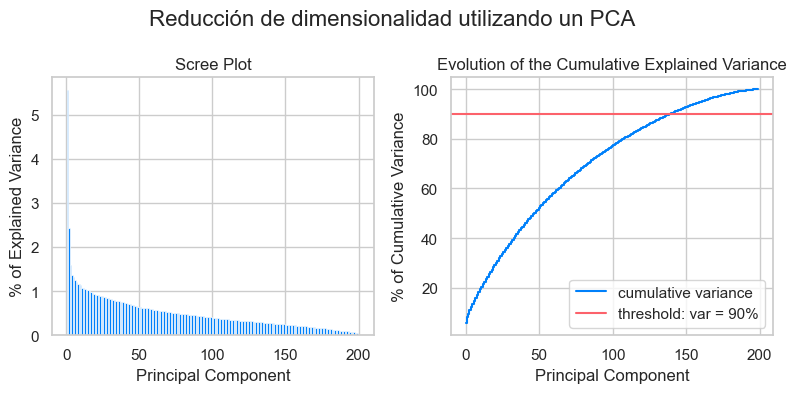

In [55]:
sns.set_style(style="whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].bar(x=range(1, len(per_var)+1), height=per_var, width=1, color="#0080fa", linewidth=0.5)
axs[0].set_ylabel('% of Explained Variance')
axs[0].set_xlabel('Principal Component')
axs[0].set_title("Scree Plot")

axs[1].step(range(0,len(cum_sum)), cum_sum, where='mid', color="#0080fa",label='cumulative variance')
axs[1].axhline(y=90, color='#fc626b', linestyle='--',label='threshold: var = 90%')
axs[1].set_ylabel("% of Cumulative Variance")
axs[1].set_xlabel('Principal Component')
axs[1].set_title("Evolution of the Cumulative Explained Variance")
axs[1].legend()
             
fig.suptitle("Reducción de dimensionalidad utilizando un PCA", fontsize=16)
fig.tight_layout()
plt.show()

In [11]:
# guardem els models segons el pca (entrenament)
labels = ['PC'+str(i) for i in range(1, 141)]
dataset_entr = pd.DataFrame(pca_data[:,:140], columns=labels)
dataset_entr.insert(140, "Type", etqs, True)
dataset_entr = dataset_entr.sample(frac=1).reset_index(drop=True)
dataset_entr.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,Type
0,-3596.042677,1065.574890,1487.660853,-180.226556,-433.427455,-34.844370,-919.915209,345.489048,147.899757,96.322494,...,-919.554671,9058.056430,4300.590239,1943.625710,11720.909289,-5797.168982,-10418.286665,-5091.062195,-3263.873342,1
1,-4888.782324,1983.761246,2006.861749,-1223.527171,-332.813102,-2058.073071,454.791783,338.172465,997.537122,983.680223,...,-105.725443,-197.481494,-160.863120,-686.305324,-173.433716,-124.234251,-214.850907,505.107096,597.453108,0
2,-5584.322569,1337.813612,1939.526985,595.934115,127.826795,-458.169941,-450.347793,-311.759301,277.788670,9.651580,...,55.799962,277.938925,-263.218553,-123.200148,314.670040,87.945036,155.980979,175.149743,497.188408,1
3,1700.019199,126.947473,540.763464,-2182.045634,1432.289046,-2337.735392,-465.730874,1179.693686,574.418720,1988.958964,...,114.463795,710.114839,-271.080948,396.055516,375.536751,-150.574980,-190.570381,-50.256039,-219.548442,0
4,-4795.208879,791.153482,1835.990870,950.991202,-414.656793,156.276803,-221.727126,-10.319499,-18.360181,-75.027458,...,-2.656172,-24.779799,-33.619802,171.277080,130.482953,250.090803,957.742190,-204.944244,260.260566,1


In [12]:
# guardem els models segons el pca (validacio)
pca_validacio = pca.transform(val_homogeni)
data_validacio = pd.DataFrame(pca_validacio[:,:140], columns=labels)
data_validacio.insert(140, "Type", etqs_validacio, True)
data_validacio = data_validacio.sample(frac=1).reset_index(drop=True)
data_validacio.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,Type
0,-1435.299054,988.063473,319.078628,-1491.213023,-452.524582,-820.432338,329.370759,81.706943,949.844728,505.949067,...,-461.886802,-266.949114,-147.735071,-347.881154,-92.025555,93.159791,-239.995404,328.269177,161.300105,0
1,9600.223788,-1953.630939,-367.274426,-157.181097,911.147284,1253.517650,166.138060,1359.881608,553.071978,1247.086582,...,-224.028996,-165.181190,178.674669,-554.698731,-411.572536,-510.554972,-129.226785,176.933637,-586.410765,0
2,-3193.494136,579.926325,989.523355,894.404630,-363.680361,-131.729517,603.997860,-285.314996,589.298903,-156.039729,...,-124.026162,-206.145672,-58.666315,-98.368579,189.552914,27.970393,256.929265,-49.138190,72.825859,1
3,221.700604,1412.418548,2263.633914,2850.190413,463.601762,139.862577,-317.076354,-1853.987613,-996.645735,-856.595693,...,-304.316136,46.277681,475.923522,-190.765754,504.026310,165.642361,31.213102,227.901710,49.639399,0
4,-4233.783966,621.114145,895.140837,535.594001,-382.200215,-269.238457,562.325071,-376.629967,203.052543,365.967693,...,267.677599,40.347026,-136.349983,17.595709,-132.370197,246.015055,147.724598,5.936355,11.164732,1


#### Models
***

In [21]:
# busquem el nombre optim d'arbres per tenir el model
param_grid = {"n_estimators": range(50, 150)}
grid_search = GridSearchCV(
    RandomForestClassifier(), param_grid=param_grid, scoring='accuracy')
grid_search.fit(dataset_entr.drop(["Type"], axis=1), dataset_entr["Type"])

print("El millor nombre d'arbres per al model és {}.".format(grid_search.best_params_["n_estimators"]))

El millor nombre d'arbres per al model és 117.


Text(0.5, 0, 'Número de Árboles')

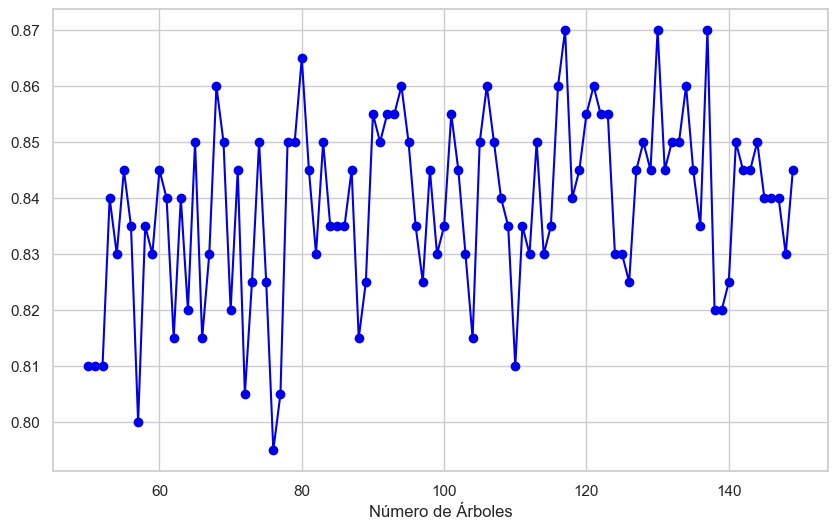

In [22]:
means = grid_search.cv_results_["mean_test_score"]

fig = plt.figure(figsize=(10, 6))

# plt.suptitle("LogisticRegression", fontsize = 'x-large', fontweight = 'bold')
plt.plot(range(50, 150), means, "o-", label="score for precission", color="#0000e9")
plt.axis('tight')
plt.xlabel('Número de Árboles')
# plt.axvline(x=clf.best_params_['C'], color='#800000', label='best C')


Veiem que els resultats no són concluents i per tant no hi haurà molta diferència entre el nombre d'arbres escollits.

#### Entrenaments
***

In [23]:
# generem el model
model = RandomForestClassifier(grid_search.best_params_["n_estimators"]).fit(dataset_entr.drop(["Type"], axis=1), dataset_entr["Type"])

#### Resultats
***

In [24]:
preds = model.predict(data_validacio.drop(["Type"], axis=1))
print("Precisió obtinguda: {}%".format(accuracy_score(data_validacio['Type'], preds)*100))

Precisió obtinguda: 90.0%


In [29]:
print(metrics.classification_report(data_validacio['Type'], preds))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        50
           1       0.83      1.00      0.91        50

    accuracy                           0.90       100
   macro avg       0.92      0.90      0.90       100
weighted avg       0.92      0.90      0.90       100



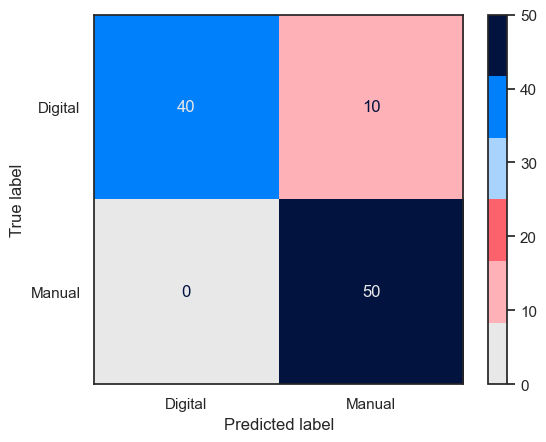

In [50]:
from sklearn import metrics
# sns.set(style="white")
# sns.color_palette(custom)
matriu_confusio = metrics.confusion_matrix(etqs_validacio, pred) 
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matriu_confusio, display_labels = ["Digital", "Manual"])
cm_display.plot(cmap=custom_palette)
plt.show()